In [1]:
import numpy as np
import os
import torch
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision.transforms import ToPILImage
from torch.utils.data import ConcatDataset
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from skimage.feature import local_binary_pattern

In [2]:
IMG_HEIGHT = 48
IMG_WIDTH = 48

# Path to the training data
TRAIN_DATA_PATH = os.path.join(os.getcwd(), '../FER with DL/data', 'train')

# Path to the test data
TEST_DATA_PATH = os.path.join(os.getcwd(), '../FER with DL/data', 'test')

# Defining transformations
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor()
])

# Load the datasets
train_dataset = ImageFolder(TRAIN_DATA_PATH, transform=transform)
test_dataset = ImageFolder(TEST_DATA_PATH, transform=transform)

# Create the dataloader for validation set only, train data still needs to be augmented
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Exploratory Data Analysis (EDA)

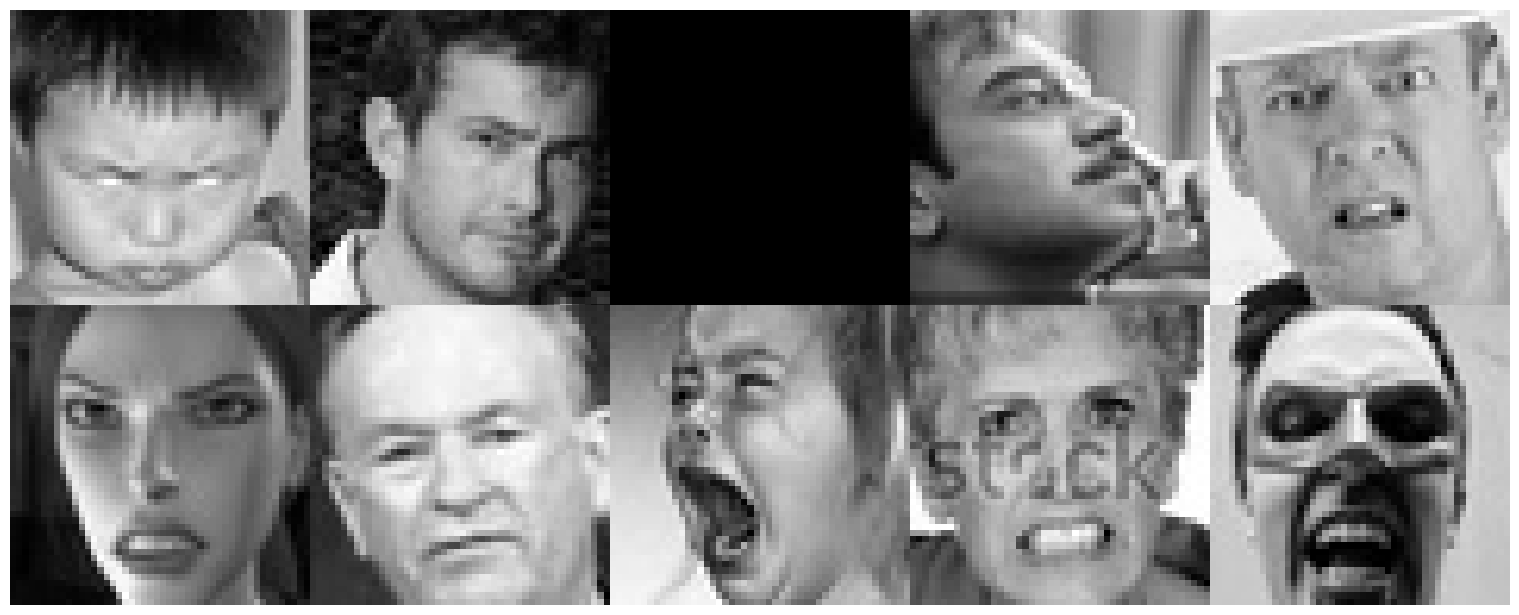

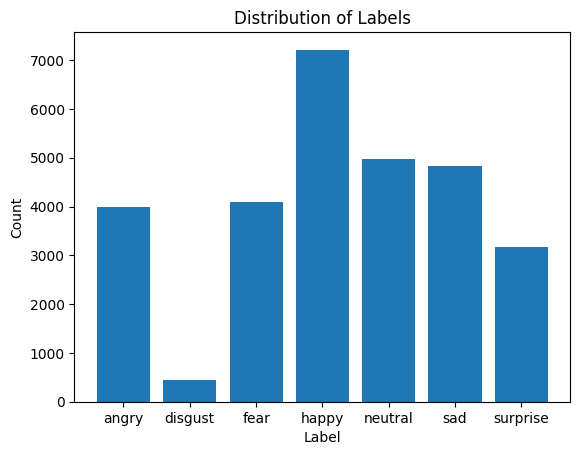

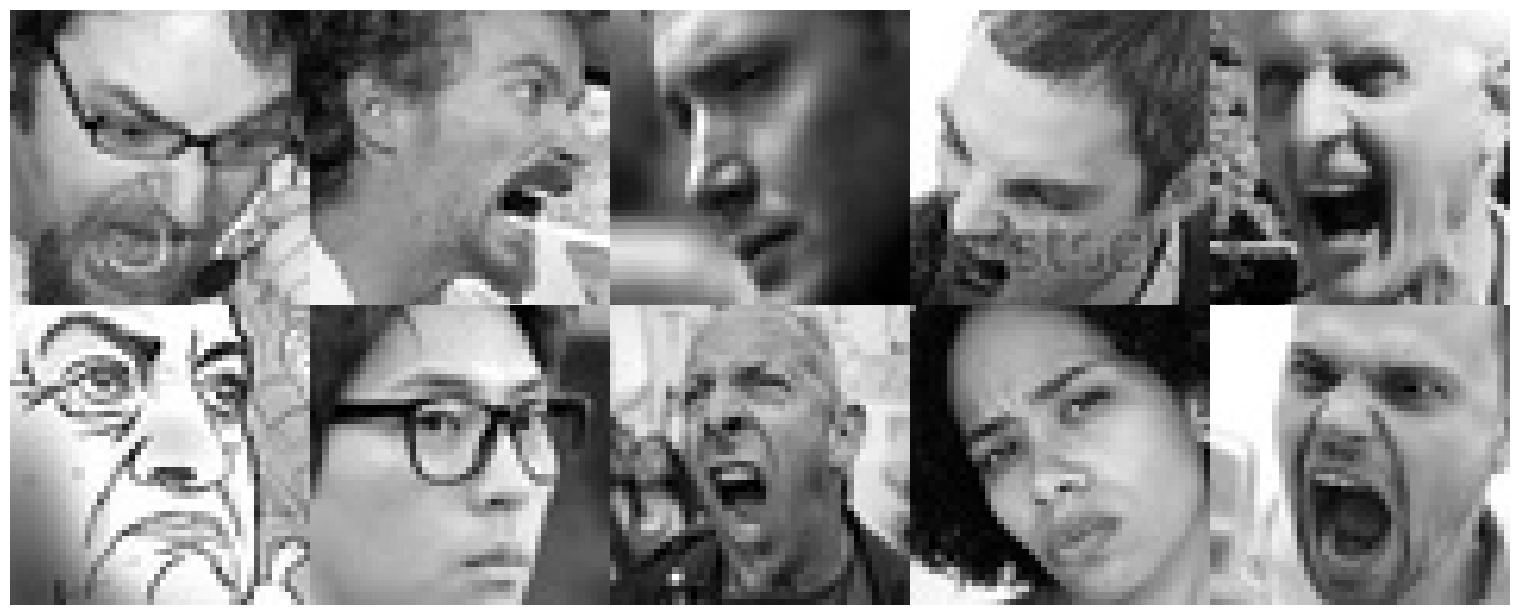

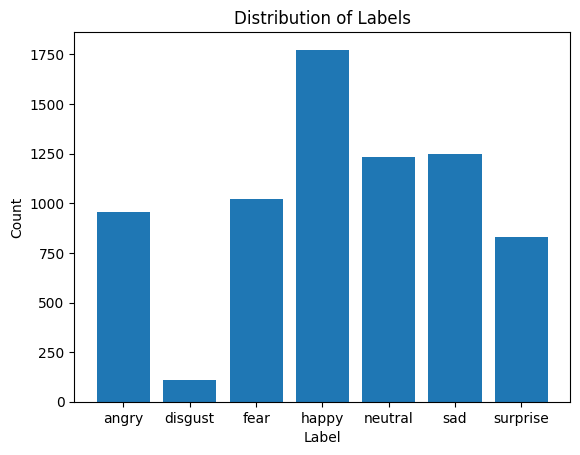

In [4]:
import matplotlib.pyplot as plt
import os
from torchvision.io import read_image

def plot_sample_images(path, n=10):
    """Plot n sample images from the given path."""
    class_folders = [os.path.join(path, f) for f in os.listdir(path) if os.path.isdir(os.path.join(path, f))]
    images = []
    for folder in class_folders:
        images.extend([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.jpg') or f.endswith('.png')])
    if len(images) < n:
        print(f"Only found {len(images)} images in {path}.")
        n = len(images)
    fig, axs = plt.subplots(2, n//2, figsize=(15, 6))
    for i in range(n):
        img_path = images[i]
        img = read_image(img_path)
        ax = axs[i // (n//2), i % (n//2)]
        ax.imshow(img.permute(1, 2, 0).squeeze(), cmap='gray')
        ax.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

def plot_label_distribution(path):
    """Plot the distribution of labels in the given path."""
    labels = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
    counts = [len(os.listdir(os.path.join(path, label))) for label in labels]
    plt.bar(labels, counts)
    plt.title('Distribution of Labels')
    plt.xlabel('Label')
    plt.ylabel('Count')
    plt.show()

# Plot sample images and label distribution for the training data
plot_sample_images(TRAIN_DATA_PATH)
plot_label_distribution(TRAIN_DATA_PATH)

# Plot sample images and label distribution for the test data
plot_sample_images(TEST_DATA_PATH)
plot_label_distribution(TEST_DATA_PATH)

In [5]:
# Takes roughly 4 minutes to run this cell

# Oversampling the disgust samples since we don't have many samples

# Define additional transformations for data augmentation
augment_transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

# Create a new dataset with only the "disgust" images
disgust_dataset = [img for img in train_dataset if img[1]
                   == train_dataset.class_to_idx['disgust']]

In [9]:
from torchvision.transforms import ToTensor

# Convert Tensor to PIL Image
to_pil = ToPILImage()

# Apply data augmentation to the "disgust" images
# There are 436 disgust files in the training data so the value after range is the mutiplier
augmented_disgust_dataset = [(augment_transform(to_pil(img[0])), img[1])
                             for _ in range(8) for img in disgust_dataset]

print(type(augmented_disgust_dataset[0][0]))

<class 'torch.Tensor'>


In [10]:
print(len(augmented_disgust_dataset))

3488


In [11]:
# Combine the original dataset with the augmented "disgust" images
train_dataset = ConcatDataset([train_dataset, augmented_disgust_dataset])

# Create the train DataLoader now that disgust images have been augmented
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Print details about the train and test datasets
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of training samples: 33505
Number of testing samples: 7178


In [12]:
# Local Binary patterns (LBP) Feature Extraction Implementation
def extract_features_lbp(data_loader):
    # Parameters for LBP
    radius = 3
    n_points = 8 * radius
    # Initialize an empty list to store the feature vectors
    features = []
    labels = []
    # Process each batch of images
    for images, batch_labels in data_loader:
        for i in range(len(images)):
            image = images[i].numpy().squeeze()
            lbp = local_binary_pattern(image, n_points, radius)
            # Flatten the LBP image and add it to the list of feature vectors
            features.append(lbp.ravel())
            labels.append(batch_labels[i].item())
    return features, labels

In [ ]:
# Eigenfaces Feature Extraction Implmentation
def extract_features_eigenfaces(data_loader):
    # Initialize an empty list to store the images and labels
    images = []
    labels = []
    # Process each batch of images
    for batch_images, batch_labels in data_loader:
        for i in range(len(batch_images)):
            image = batch_images[i].numpy().squeeze()
            # Flatten the image and add it to the list of images
            images.append(image.ravel())
            labels.append(batch_labels[i].item())
    # Convert the lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    # Apply PCA to the images
    pca = PCA(n_components=150)
    features = pca.fit_transform(images)
    return features, labels

In [ ]:
# Fisherfaces Feature Extraction Implementation
def extract_features_fisherfaces(data_loader):
    # Initialize an empty list to store the images and labels
    images = []
    labels = []
    # Process each batch of images
    for batch_images, batch_labels in data_loader:
        for i in range(len(batch_images)):
            image = batch_images[i].numpy().squeeze()
            # Flatten the image and add it to the list of images
            images.append(image.ravel())
            labels.append(batch_labels[i].item())
    # Convert the lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    # Apply PCA to the images
    pca = PCA(n_components=150)
    pca_result = pca.fit_transform(images)
    # Apply LDA to the PCA result
    lda = LDA(n_components=None)
    features = lda.fit_transform(pca_result, labels)
    return features, labels

In [13]:
# Takes roughly 4 minutes to run this cell
# Subsititute the function name based on the feature extraction method you want to use
X_train, y_train = extract_features_lbp(train_loader)

c:\Users\Stekunda\anaconda3\envs\FER\lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


In [14]:
# Takes roughly 4 minutes to run this cell
# Subsititute the function name based on the feature extraction method you want to use
X_test, y_test = extract_features_lbp(test_loader)

In [15]:

print(f"Number of feature vectors: {len(X_train)}")
print(f"Shape of a feature vector: {X_train[0].shape}")


Number of feature vectors: 33505
Shape of a feature vector: (2304,)


In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB
import seaborn as sns

def train_and_evaluate(X_train, y_train, X_test, y_test, model):
    # Create a SVM (Support Vector Machine) classifier
    # clf = KNeighborsClassifier()
    clf = model

    # Train the model with the training data and labels
    clf.fit(X_train, y_train)

    # Get the name of the model
    model_name = type(model).__name__

    # Create the filename
    filename = f'{model_name}_model.pth'

    # Save the model
    torch.save(model, filename)

    # Predict the labels of the test data
    y_pred = clf.predict(X_test)

    # Calculate the model accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate precision, recall, and F1-score
    report = classification_report(y_test, y_pred)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

    print(f"Accuracy: {accuracy * 100}%")
    print("Classification Report:")
    print(report)

K-Nearest Neighbors Classifier
Accuracy: 38.01894678183338%
Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.28      0.28       958
           1       0.14      0.59      0.23       111
           2       0.35      0.26      0.30      1024
           3       0.46      0.62      0.53      1774
           4       0.33      0.39      0.36      1233
           5       0.35      0.16      0.22      1247
           6       0.59      0.42      0.49       831

    accuracy                           0.38      7178
   macro avg       0.36      0.39      0.34      7178
weighted avg       0.39      0.38      0.37      7178

Random Forest Classifier
Accuracy: 39.8300362217888%
Classification Report:
              precision    recall  f1-score   support

           0       0.37      0.16      0.22       958
           1       0.64      0.27      0.38       111
           2       0.41      0.18      0.25      1024
           3       0.39    

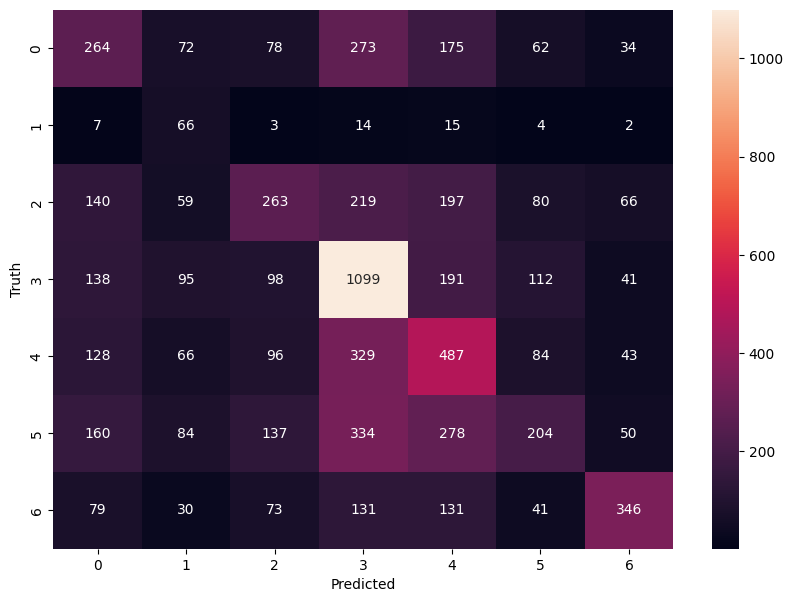

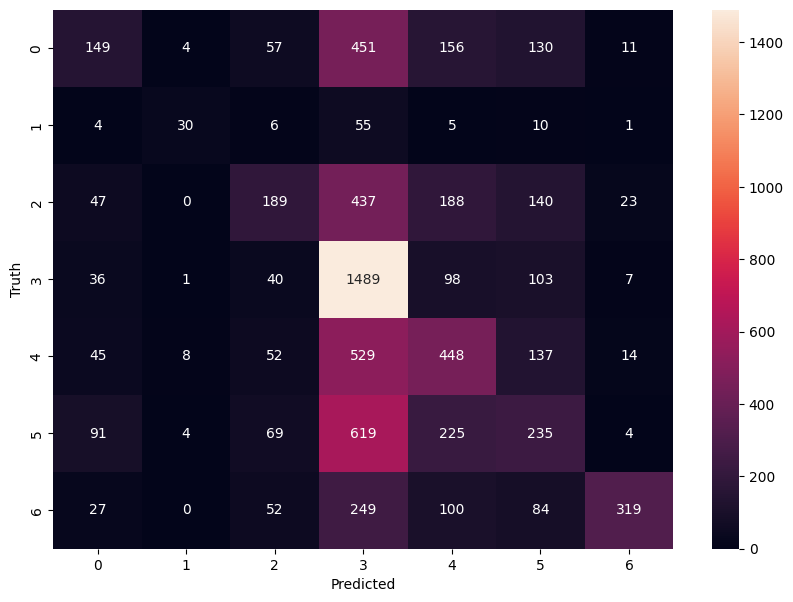

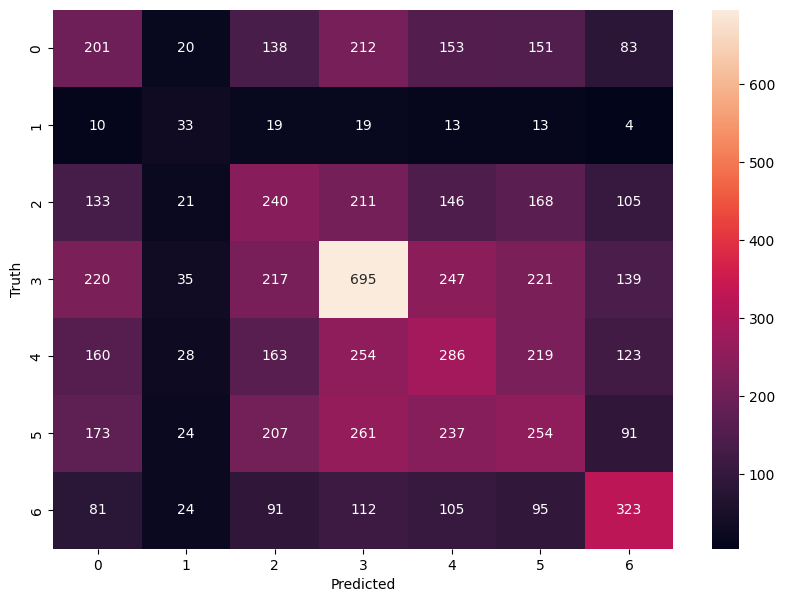

In [19]:
print("K-Nearest Neighbors Classifier")
train_and_evaluate(X_train, y_train, X_test, y_test, KNeighborsClassifier())

print("Random Forest Classifier")
train_and_evaluate(X_train, y_train, X_test, y_test, RandomForestClassifier())

print("Decision Tree Classifier")
train_and_evaluate(X_train, y_train, X_test, y_test, DecisionTreeClassifier())

# print("Gradient Boosting Classifier")
# train_and_evaluate(X_train, y_train, X_test, y_test, GradientBoostingClassifier())

# print("Logistic Regression Classifier")
# train_and_evaluate(X_train, y_train, X_test, y_test, LogisticRegression())

# print("Linear Regression Classifier")
# train_and_evaluate(X_train, y_train, X_test, y_test, LinearRegression())

# print("Gaussian Naive Bayes Classifier")
# train_and_evaluate(X_train, y_train, X_test, y_test, GaussianNB())

# print("Support Vector Machine Classifier")
# train_and_evaluate(X_train, y_train, X_test, y_test, SVC())

In [14]:
# Displays the class labels and their corresponding indices
print(test_dataset.class_to_idx)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
